# Options

In [1]:
saving = False

selected_scenarios = [
    #'bella_single_mobile',
    #'bella_allbut1_mobile',
    'bella_all_mobile',
    #'bella_static',
]
fig_path = "/dev/shm/"

_texcol=0.5
_texfac=1.0

# Setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import aietes
import os
from bounos import ChartBuilders as cb


result_h5s_by_latest = sorted(
        filter(
                lambda p: os.path.basename(p).endswith("h5"),
                map(lambda p: os.path.abspath(os.path.join(aietes.Tools._results_dir, p)),
                    os.listdir(aietes.Tools._results_dir))
        ), key=lambda f: os.path.getmtime(f)
)
rate_and_ranges = filter(
        lambda p: os.path.basename(p).startswith("CommsRateAndRangeTest"),
        result_h5s_by_latest
)

def app_rate_from_path(s):
    return float(".".join(s.split('-')[2].split('.')[0:-1]))

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Physical Node Layout 
s1_layout

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


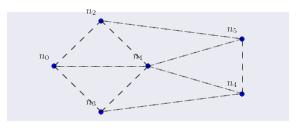

In [3]:
figsize = cb.latexify(columns=_texcol, factor=_texfac)

base_config = aietes.Simulation.populate_config(
                aietes.Tools.get_config('bella_static.conf'),
                retain_default=True
)
_texify = lambda t: "${}_{}$".format(t[0], t[1])
node_positions = {_texify(k): np.asarray(v['initial_position'], dtype=float) for k, v in
                  base_config['Node']['Nodes'].items() if 'initial_position' in v}
node_links = {0: [1, 2, 3], 1: [0, 1, 2, 3, 4, 5], 2: [0, 1, 5], 3: [0, 1, 4], 4: [1, 3, 5], 5: [1, 2, 4]}

fig = cb.plot_nodes(node_positions, figsize=(4, 1.6), node_links=node_links, radius=3, scalefree=True,
                    square=False)
fig.tight_layout(pad=0.3)

if saving:
    fig.savefig("s1_layout." + img_extn, transparent=True)
fig.show()

# Rate and Range performance

In [ ]:
rename_labels = {"rx_counts": "Received Packets",
                 "tx_counts": "Transmitted Packets",
                 "enqueued": "Enqueued Packets",
                 "collisions": "Collisions"}

scenario = selected_scenarios[0]

In [4]:
figsize = cb.latexify(columns=_texcol, factor=_texfac)
statsd = {}

for store_path in filter(lambda s: scenario in s, rate_and_ranges):
    with pd.get_store(store_path) as s:
        try:
            stats = s.get('stats')
        except KeyError:
            print store_path
            print s.keys()
            raise
        # Reset Range for packet emission rate
        stats.index = stats.index.set_levels([
                                                 np.int32((np.asarray(
                                                         stats.index.levels[0].astype(np.float64)) * 100)),
                                                 # Var
                                                 stats.index.levels[1].astype(np.int32)  # Run
                                             ] + (stats.index.levels[2:])
                                             )
        statsd[app_rate_from_path(store_path)] = stats.copy()

df = pd.concat(statsd.values(), keys=statsd.keys(), names=['rate', 'separation'] + stats.index.names[1:])
base_df = df.reset_index().sort_index(level=['rate', 'separation']).set_index(['rate', 'separation', 'run', 'node'])


def plot_subcolumns(grp, rename_labels=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    plt_grp = grp.copy()
    plt_grp.index.name = var
    if rename_labels:
        plt_grp.rename(columns=rename_labels, inplace=True)
    plt_grp.plot(ax=ax,
             #secondary_y=labels['collisions'],  # subplots=True,
             style=["-", "--", "-.", ":"],
             grid='on',
             )
    axes=f.get_axes()
    #axes[1].set_yticks(np.linspace(axes[1].get_yticks()[0],axes[1].get_yticks()[-1],len(axes[0].get_yticks())))

    ax.set_xlabel(var)
    ax.set_ylabel("Total Packets")
    return f

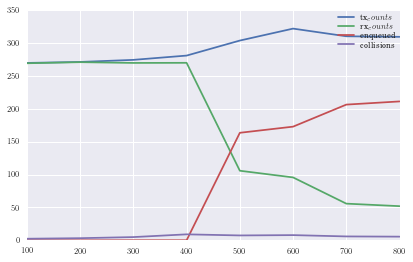

In [34]:
for k,v in grp.iteritems():
    plt.plot(v, label=k)
plt.legend()


## Emissions Rate Performance

In [14]:
var = "Packet Emmission Rate (pps)"
prefix = "emission"
initial_var = 100#m

stats = base_df.swaplevel('rate', 'separation').xs(initial_var, level='separation')
stats.index.names = ['var'] + stats.index.names[1:]

# Reset Range for packet emission rate
stats.index = stats.index.set_levels([
                                         stats.index.levels[0].astype(np.float64),  # Var
                                         stats.index.levels[1].astype(np.int32)  # Run
                                     ] + (stats.index.levels[2:])
                                     )
stats = stats.sortlevel(axis=0, level=0, sort_remaining=True)



(0, 1)

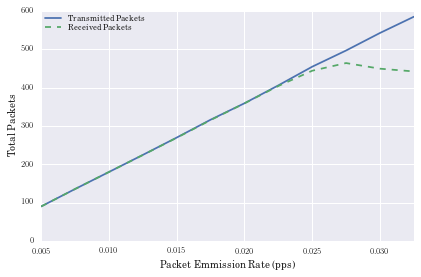

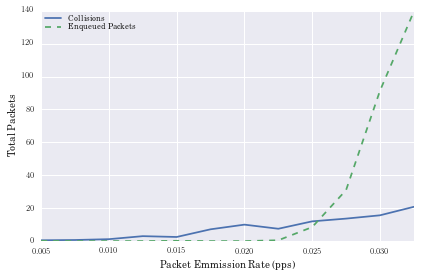

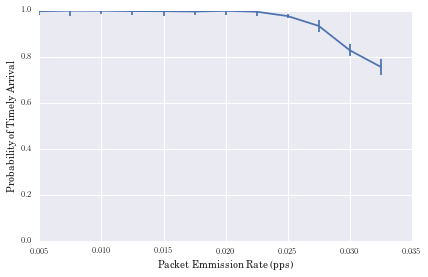

In [15]:
if subplots:
    figsize = (figsize[0], figsize[1]*3)

labels = {s: s for s in stats.keys()}
labels.update(rename_labels)

grp = stats.groupby(level='var')[['tx_counts', 'rx_counts', 'enqueued', 'collisions']].mean()

if title is not False:
    title="Performance Comparison of Varying {},{}".format(var, (':' + title if title is not None else ""))

grp.index = grp.index.astype(np.float64)

    
emission_packet_stats = plot_subcolumns(grp[['tx_counts','rx_counts']],rename_labels=rename_labels)
emission_collqueue_stats = plot_subcolumns(grp[['collisions','enqueued']],rename_labels=rename_labels)

emission_timely, ax = plt.subplots(1, 1, figsize=figsize)
packet_error_rates = (stats.rx_counts / stats.tx_counts).groupby(level='var').mean()
packet_error_vars = (stats.rx_counts / stats.tx_counts).groupby(level='var').std()
ax.errorbar(list(packet_error_rates.index), packet_error_rates.values, packet_error_vars.values)
ax.set_ylabel("Probability of Timely Arrival")
ax.set_xlabel(var)
ax.set_ylim(0, 1)

In [25]:
var = "Node Separation (m)"

initial_var = 0.015#pps
subplots = False
title = False

stats = base_df.xs(initial_var, level='rate')
stats.index.names = ['var'] + stats.index.names[1:]

# Reset Range for packet emission rate
stats.index = stats.index.set_levels([
                                         stats.index.levels[0].astype(np.float64),  # Var
                                         stats.index.levels[1].astype(np.int32)  # Run
                                     ] + (stats.index.levels[2:])
                                     )
stats = stats.sortlevel(axis=0, level=0, sort_remaining=True)

(0, 1)

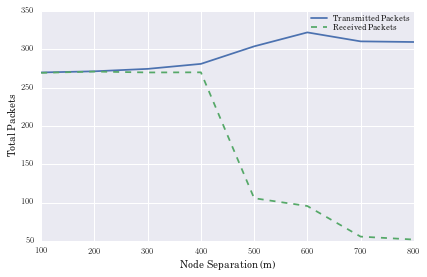

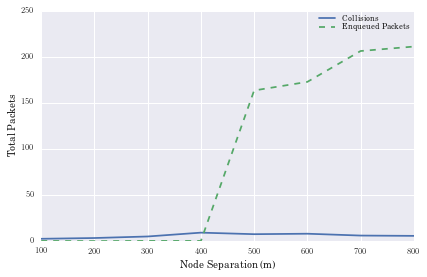

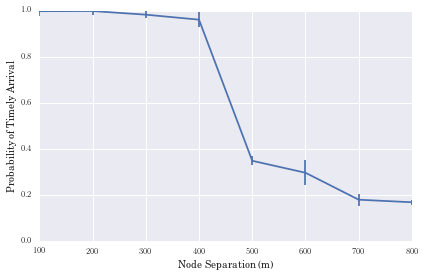

In [26]:
figsize = cb.latexify(columns=_texcol, factor=_texfac)

if subplots:
    figsize = (figsize[0], figsize[1]*3)

labels = {s: s for s in stats.keys()}
labels.update(rename_labels)

grp = stats.groupby(level='var')[['tx_counts', 'rx_counts', 'enqueued', 'collisions']].mean()

if title is not False:
    title="Performance Comparison of Varying {},{}".format(var, (':' + title if title is not None else ""))

grp.index = grp.index.astype(np.float64)

    
separation_packet_stats = plot_subcolumns(grp[['tx_counts','rx_counts']],rename_labels=rename_labels)
separation_collqueue_stats = plot_subcolumns(grp[['collisions','enqueued']],rename_labels=rename_labels)

separation_timely, ax = plt.subplots(1, 1, figsize=figsize)
packet_error_rates = (stats.rx_counts / stats.tx_counts).groupby(level='var').mean()
packet_error_vars = (stats.rx_counts / stats.tx_counts).groupby(level='var').std()
ax.errorbar(list(packet_error_rates.index), packet_error_rates.values, packet_error_vars.values)
ax.set_ylabel("Probability of Timely Arrival")
ax.set_xlabel(var)
ax.set_ylim(0, 1)

# Table Stats

In [49]:
selected_scenarios = [
    'bella_single_mobile',
    'bella_allbut1_mobile',
    'bella_all_mobile',
    'bella_static',
]
scenario_map = {
    'bella_single_mobile':"Single Mobile",
    'bella_allbut1_mobile': "All-but-one",
    'bella_all_mobile': "All Mobile",
    'bella_static': "All Static"
}

statsd = {}
statsdd = {}
for scenario in selected_scenarios:
    for store_path in filter(lambda s: scenario in s, rate_and_ranges):
        with pd.get_store(store_path) as s:
            try:
                stats = s.get('stats')
            except KeyError:
                print store_path
                print s.keys()
                raise
            # Reset Range for packet emission rate
            stats.index = stats.index.set_levels([
                                                     np.int32((np.asarray(
                                                             stats.index.levels[0].astype(np.float64)) * 100)),
                                                     # Var
                                                     stats.index.levels[1].astype(np.int32)  # Run
                                                 ] + (stats.index.levels[2:])
                                                 )
            statsd[app_rate_from_path(store_path)] = stats.copy()

    df = pd.concat(statsd.values(), keys=statsd.keys(), names=['rate', 'separation'] + stats.index.names[1:])
    base_df = df.reset_index().sort_index(level=['rate', 'separation']).set_index(['rate', 'separation', 'run', 'node'])
    statsdd[scenario_map[scenario]] = base_df.copy(deep=True)

In [57]:
super_df = pd.concat(statsdd.values(), keys=statsdd.keys(), 
                     names=['mobility', 'rate','separation','run', 'node'])


## Emissions

In [77]:
var = "Packet Emmission Rate (pps)"
prefix = "emission"
initial_var = 100#m

super_stats = super_df.swaplevel('rate', 'separation').xs(initial_var, level='separation')

# Reset Range for packet emission rate
super_stats.index = super_stats.index.set_levels([
                                        super_stats.index.levels[0],
                                         super_stats.index.levels[1].astype(np.float64),  # Var
                                         super_stats.index.levels[2].astype(np.int32)  # Run
                                     ] + (super_stats.index.levels[3:])
                                     )
super_stats = super_stats.sortlevel(axis=0, level=0, sort_remaining=True)


super_stats['error_rate'] = super_stats.rx_counts/super_stats.tx_counts
colmap={'error_rate':'Probability of Arrival','average_rx_delay':'Delay(s)'}
table = super_stats[['average_rx_delay','error_rate']].groupby(level=['mobility','rate']).mean().rename(columns=colmap)

ratio = (super_stats.rts_counts / super_stats.rx_counts)
r_mean = ratio.groupby(level=['mobility','rate']).mean()
table['RTS/Data Ratio'] = r_mean

table.index.set_names(['Mobility',var],inplace=True)



table.reset_index(inplace=True)
#table['Ideal Delivery Time(s)'] = table[var]/1400.0 + 9600.0/(10000.0)

tex=table.to_latex(float_format=lambda x:"%1.4f"%x, index=False, column_format="""
*{2}{@{\\hspace{1em}}r@{\\hspace{1em}}}
*{3}{@{\\hspace{1em}}p{0.1\\textwidth} @{\\hspace{1em}}}  """)
#with open('input/range_delay_table.tex','w') as f:
#    f.write(tex)
print tex   
table

\begin{tabular}{
*{2}{@{\hspace{1em}}r@{\hspace{1em}}}
*{3}{@{\hspace{1em}}p{0.1\textwidth} @{\hspace{1em}}}  }
\toprule
      Mobility &  Packet Emmission Rate (pps) &  Delay(s) &  Probability of Arrival &  RTS/Data Ratio \\
\midrule
    All Static &                       0.0050 &    2.1030 &                  1.0001 &          1.0982 \\
    All Static &                       0.0075 &    2.8033 &                  0.9952 &          1.1808 \\
    All Static &                       0.0100 &    3.3836 &                  0.9991 &          1.1547 \\
    All Static &                       0.0125 &    4.9682 &                  0.9979 &          1.2269 \\
    All Static &                       0.0150 &    7.3676 &                  0.9983 &          1.3189 \\
    All Static &                       0.0175 &    9.5466 &                  0.9985 &          1.3648 \\
    All Static &                       0.0200 &   14.2142 &                  0.9978 &          1.4618 \\
    All Static &              

,Mobility,Packet Emmission Rate (pps),Delay(s),Probability of Arrival,RTS/Data Ratio
0,All Static,0.0050,2.102964,1.000112,1.098158
1,All Static,0.0075,2.803283,0.995169,1.180846
2,All Static,0.0100,3.383572,0.999105,1.154730
3,All Static,0.0125,4.968177,0.997940,1.226910
4,All Static,0.0150,7.367639,0.998268,1.318913
5,All Static,0.0175,9.546578,0.998490,1.364825
6,All Static,0.0200,14.214231,0.997759,1.461773
7,All Static,0.0225,20.659816,0.996819,1.498960
8,All Static,0.0250,71.475752,0.988169,1.816177
9,All Static,0.0275,792.806223,0.897822,2.294497


In [76]:
ratio

mobility       rate    run  node
All Static     0.0050  0    n0      1.054945
                            n1      1.055556
                            n2      1.010870
                            n3      1.043956
                            n4      1.111111
                            n5      1.055556
                       1    n0      1.010989
                            n1      1.067416
                            n2      1.120879
                            n3      1.088889
                            n4      1.065217
                            n5      1.164835
                       2    n0      1.022222
                            n1      1.144444
                            n2      1.055556
                            n3      1.076087
                            n4      1.166667
                            n5      1.076923
                       3    n0      1.022222
                            n1      1.101124
                            n2      1.044944
                      

# BIANCHI

In [ ]:
def _p(pi, N):
    return 1-(1-pi)**(N-1)
def _pi()